<a href="https://colab.research.google.com/github/aKhalid1476/cnn_exoplanet_detector/blob/main/ExoplanetDetectorCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df_train = pd.read_csv('exoTrain.csv')
df_train['LABEL'] = df_train['LABEL'] -1
df_test = pd.read_csv('exoTest.csv')
df_test['LABEL'] = df_test['LABEL'] - 1

def plot_graphs(history, best):

  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def analyze_results(model, X_train, y_train, X_test, y_test):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    X_train: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    y_train : array-like of shape (n_samples,)
    Target values for model training.
    X_test: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    y_test : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    if type(model) == keras.src.models.sequential.Sequential:
      train_predictions = model.predict(X_train)
      train_predictions = (train_predictions > 0.5)
      cm = confusion_matrix(y_train, train_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - Training Data')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      plt.close()
      ConfusionMatrixDisplay.from_estimator(model,X_train,y_train)
      plt.show()

    print("Testing:")
    if type(model) == keras.src.models.sequential.Sequential:
      test_predictions = model.predict(X_test)
      test_predictions = (test_predictions > 0.5)
      cm = confusion_matrix(y_test, test_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - Test Data')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)

X_train = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

exoTrain.csv        100%[===================>] 250.08M   127MB/s    in 2.0s    
exoTest.csv         100%[===================>]  27.57M   107MB/s    in 0.3s    


In [ ]:
# Helper functions that run for the three augmentation functions that will be used

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    X_train = np.abs(np.fft.fft(df1, axis=1))
    X_test = np.abs(np.fft.fft(df2, axis=1))
    return X_train,X_test

def norm(df1,df2):
    X_train = normalize(df1)
    X_test = normalize(df2)
    return X_train,X_test

def robust(df1,df2):
    scaler = RobustScaler()
    X_train = scaler.fit_transform(df1)
    X_test = scaler.transform(df2)
    return X_train,X_test

fourier_X_train, fourier_X_test = fourier(X_train, X_test)
savgol_X_train, savgol_X_test = savgol(fourier_X_train, fourier_X_test)
norm_X_train, norm_X_test = norm(savgol_X_train,savgol_X_test)
robust_X_train, robust_X_test = robust(norm_X_train, norm_X_test)
smote_X_train,smote_y_train = smote(robust_X_train, y_train)

In [ ]:
cnn_smote_X_train = np.expand_dims(smote_X_train, axis=2)
cnn_smote_y_train = smote_y_train

############

cnn_preprocess_X_test = np.expand_dims(robust_X_test, axis=2)
cnn_preprocess_y_test = y_test

############

cnn_X_train = np.expand_dims(X_train, axis=2)
cnn_y_train = y_train

############

cnn_X_test = np.expand_dims(X_test, axis=2)
cnn_y_test = y_test

############

In [ ]:
# Create model

# initialize model
model = Sequential()
input_shape = [3197, 1]

################

model.add(Conv1D(8, 5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model.add(Conv1D(16, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

####################

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
#Train the Model
history = model.fit(cnn_smote_X_train, cnn_smote_y_train, batch_size=64, epochs=20, verbose=1, validation_data=(cnn_preprocess_X_test, cnn_preprocess_y_test), shuffle=True)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8558 - loss: 0.3282 - val_accuracy: 0.9561 - val_loss: 0.1580
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9791 - loss: 0.0721 - val_accuracy: 0.9912 - val_loss: 0.0792
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9890 - loss: 0.0383 - val_accuracy: 0.9807 - val_loss: 0.0794
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9896 - loss: 0.0318 - val_accuracy: 0.9912 - val_loss: 0.0581
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.9942 - loss: 0.0199 - val_accuracy: 0.9912 - val_loss: 0.0588
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.9944 - loss: 0.0168 - val_accuracy: 0.9930 - val_loss: 0.0520
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9978 - loss: 0.0099 - val_accuracy: 0.9912 - val_loss: 0.0505
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9982 - loss: 0.0083 - 

-------------------------------------------
Model Results

Training:
316/316 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


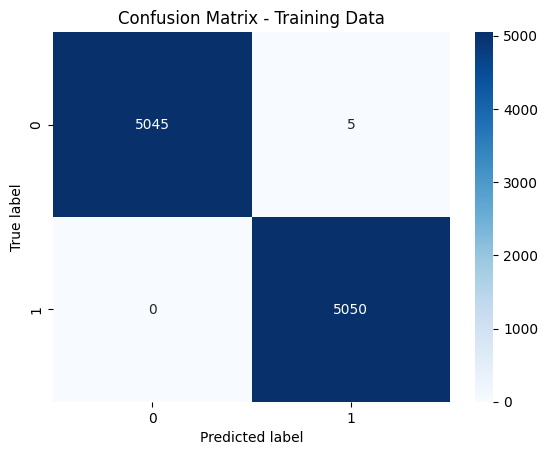

Testing:
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


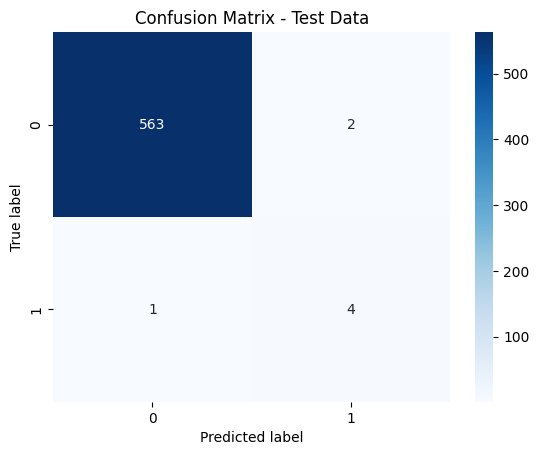

In [ ]:
analyze_results(model, cnn_smote_X_train, cnn_smote_y_train, cnn_preprocess_X_test, cnn_preprocess_y_test)

In [ ]:
from google.colab import drive
import os
import zipfile

drive.mount('/content/gdrive')
save_path = "/content/gdrive/My Drive/cnn_exoplanets.zip"

if not os.path.exists('cnn'): os.mkdir('cnn')
tf.keras.models.save_model(model,'cnn/cnn.keras')

def zipdir(path, ziph):
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))


zipf = zipfile.ZipFile(save_path, 'w', zipfile.ZIP_DEFLATED)
zipdir('cnn', zipf)
zipf.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
